<a href="https://colab.research.google.com/github/juhumkwon/DeepLearning/blob/main/Actor_Critic_(CartPole_%EC%98%88%EC%A0%9C).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 50: Total Reward = 34.0
Episode 100: Total Reward = 32.0
Episode 150: Total Reward = 43.0
Episode 200: Total Reward = 66.0
Episode 250: Total Reward = 73.0
Episode 300: Total Reward = 85.0


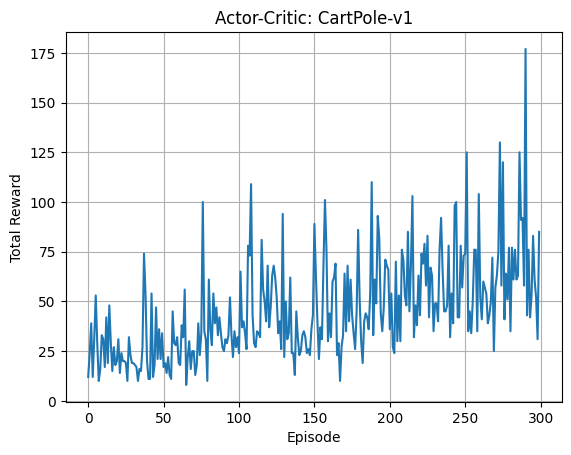

In [1]:
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pyplot as plt

# 환경 설정
# Use new_step_api=True for compatibility with newer gym versions
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# 정책 신경망 (Actor)
class Actor(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.d1 = tf.keras.layers.Dense(24, activation='relu')
        self.out = tf.keras.layers.Dense(action_size)

    def call(self, x):
        x = self.d1(x)
        return tf.nn.softmax(self.out(x))

# 가치 신경망 (Critic)
class Critic(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.d1 = tf.keras.layers.Dense(24, activation='relu')
        self.out = tf.keras.layers.Dense(1)

    def call(self, x):
        x = self.d1(x)
        return self.out(x)

# 모델 초기화
actor = Actor()
critic = Critic()
actor_optimizer = tf.keras.optimizers.Adam(0.001)
critic_optimizer = tf.keras.optimizers.Adam(0.002)

# 행동 선택
def get_action(state):
    state = tf.convert_to_tensor([state], dtype=tf.float32)
    probs = actor(state)
    action = tf.random.categorical(tf.math.log(probs), 1)
    return int(action[0, 0]), probs[0]

# 학습
def train_step(state, action, reward, next_state, terminated, truncated):
    state = tf.convert_to_tensor([state], dtype=tf.float32)
    next_state = tf.convert_to_tensor([next_state], dtype=tf.float32)

    with tf.GradientTape(persistent=True) as tape:
        v = critic(state)[0, 0]
        v_next = critic(next_state)[0, 0]
        # Use terminated or truncated to determine if the episode is done
        target = reward + (1 - int(terminated or truncated)) * 0.99 * v_next
        td_error = target - v

        critic_loss = td_error**2

        probs = actor(state)
        log_prob = tf.math.log(probs[0, action] + 1e-8)
        actor_loss = -log_prob * td_error

    actor_grads = tape.gradient(actor_loss, actor.trainable_variables)
    critic_grads = tape.gradient(critic_loss, critic.trainable_variables)
    actor_optimizer.apply_gradients(zip(actor_grads, actor.trainable_variables))
    critic_optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))
    del tape

# 학습 루프
episodes = 300
scores = []

for ep in range(episodes):
    # env.reset() now returns a tuple of (observation, info)
    state, _ = env.reset()
    total_reward = 0
    while True:
        action, _ = get_action(state)
        # env.step() now returns a tuple of (observation, reward, terminated, truncated, info)
        next_state, reward, terminated, truncated, _ = env.step(action)
        train_step(state, action, reward, next_state, terminated, truncated)
        state = next_state
        total_reward += reward
        # Check for termination or truncation to end the episode
        if terminated or truncated:
            break
    scores.append(total_reward)
    if (ep + 1) % 50 == 0:
        print(f"Episode {ep+1}: Total Reward = {total_reward}")

# 결과 시각화
plt.plot(scores)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Actor-Critic: CartPole-v1")
plt.grid()
plt.show()

In [2]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1


In [4]:
!pip install gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 10.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827729 sha256=e7ef8c76d85f143fdb4f650cf1135f5e6246d8a956857ff0ce7b8fdcf9ab41a7
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym


In [9]:
!pip install gym==0.21.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [11]:
!pip install numpy==1.26.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 85.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.0 which is incompatible.
